In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

In [2]:
X,y = sklearn.datasets.make_moons(200, noise = 0.15)

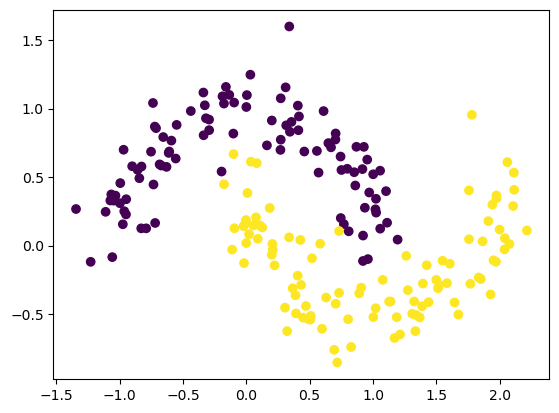

In [3]:
plt.scatter(X[:,0],X[:,1], c=y)

In [4]:
print(X.shape, y.shape)

(200, 2) (200,)


In [5]:
input_neurons = 2
output_neurons = 2
samples = X.shape[0]
learning_rate = 0.001
lambda_reg = 0.01

In [6]:
def retreive(model_dict):
    W1 = model_dict['W1']
    b1 = model_dict['b1']
    W2 = model_dict['W2']
    b2 = model_dict['b2']
    return W1, b1, W2, b2

In [7]:
def forward(x, model_dict):
    W1, b1, W2, b2 = retreive(model_dict)
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True) 
    return z1, a1, softmax

In [8]:
def loss(softmax, y, model_dict):
    W1, b1, W2, b2 = retreive(model_dict)
    m = np.zeros(200)
    for i,correct_index in enumerate(y):
        predicted = softmax[i][correct_index]
        m[i] = predicted
    log_prob = -np.log(m)
    loss = np.sum(log_prob)
    reg_loss = lambda_reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss+= reg_loss
    return float(loss / y.shape[0])

In [9]:
def predict(model_dict, x):
    W1, b1, W2, b2 = retreive(model_dict)
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)   # (200,2)
    return np.argmax(softmax, axis = 1)    # (200,)

### Equations for Backprop

![backprop](https://user-images.githubusercontent.com/30661597/67566804-3e405980-f75b-11e9-9e19-f3c388745c0a.png)

## $\frac{\partial L}{\partial y_{1}}=-\tilde{y}_{1}\left[\frac{\left(y_{1}\right)^{\prime}}{y_{1}}\right]=-\tilde{y}_{1}\left[\frac{1}{y_{1}}\right]$

## $\frac{\partial y_{1}}{\partial z_{1}}=\frac{\partial}{\partial z_{1}} \cdot \frac{e^{z_{1}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}$

![der](https://user-images.githubusercontent.com/46392773/56460220-ec94cc00-63d1-11e9-91d1-b4e3c57c81fd.png)


## $\frac{\partial L}{\partial y_{1}} \frac{\partial y_{1}}{\partial z_{1}}=-\tilde{y}_{1}\left[\frac{1}{y_{1}}\right]\frac{\partial y_{1}}{\partial z_{1}}=-\tilde{y}_{1}\left[\frac{y_{1}\left(1-y_{1}\right)}{y_{1}}\right]=-\tilde{y}_{1}\left(1-y_{1}\right)$

Recall that our labels are in the form of a one-hot vector: (ex. If class 1 is correct, then the corresponding label is [1,0], if class 2 is correct, then the corresponding label is [0,1]).

If class one is the actual prediction: $\tilde{y}_{1} = 1 $, then we have:

## $\frac{\partial L}{\partial y_{1}} \frac{\partial y_{1}}{\partial z_{1}} = -1(1-y_{1}) = y_{1} - 1 = \delta_{3}$

## $\delta_{2}=\left(1-\tanh ^{2} z_{1}\right) \circ \delta_{3} W_{2}^{T}$

## $\frac{\partial L}{\partial W_{2}}=a_{1}^{T} \delta_{3}$

## $\frac{\partial L}{\partial b_{2}}=\delta_{3}$

## $\frac{\partial L}{\partial W_{1}}=x^{T} \delta 2$

## $\frac{\partial L}{\partial b_{1}}=\delta 2$

In [10]:
def backpropagation(x, y, model_dict, epochs):
    for i in range(epochs):
        W1, b1, W2, b2 = retreive(model_dict)
        z1, a1, probs = forward(x, model_dict)    # a1: (200,3), probs: (200,2)
        delta3 = np.copy(probs)
        delta3[range(x.shape[0]), y] -= 1      # (200,2)
        dW2 = (a1.T).dot(delta3)               # (3,2)
        db2 = np.sum(delta3, axis=0, keepdims=True)        # (1,2)
        delta2 = delta3.dot(W2.T) * (1 - np.power(np.tanh(z1), 2))
        dW1 = np.dot(x.T, delta2)
        db1 = np.sum(delta2, axis=0)
        # Add regularization terms
        dW2 += lambda_reg * np.sum(W2)  
        dW1 += lambda_reg * np.sum(W1)  
        # Update Weights: W = W + (-lr*gradient) = W - lr*gradient
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
        # Update the model dictionary
        model_dict = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        # Print the loss every 50 epochs
        if i%50 == 0:
            print("Loss at epoch {} is: {:.3f}".format(i,loss(probs, y, model_dict)))
            
    return model_dict

In [11]:
# Define Initial Weights
def init_network(input_dim, hidden_dim, output_dim):
    model = {}
    # Xavier Initialization 
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b2 = np.zeros((1, output_dim))
    model['W1'] = W1
    model['b1'] = b1
    model['W2'] = W2
    model['b2'] = b2
    return model

In [12]:
def plot_decision_boundary(pred_func): 
    """
    Code adopted from: https://github.com/dennybritz/nn-from-scratch
    """
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
    plt.title("Decision Boundary for hidden layer size 3")

Loss at epoch 0 is: 0.823
Loss at epoch 50 is: 0.356
Loss at epoch 100 is: 0.307
Loss at epoch 150 is: 0.299
Loss at epoch 200 is: 0.298
Loss at epoch 250 is: 0.297
Loss at epoch 300 is: 0.297
Loss at epoch 350 is: 0.297
Loss at epoch 400 is: 0.296
Loss at epoch 450 is: 0.296
Loss at epoch 500 is: 0.295
Loss at epoch 550 is: 0.295
Loss at epoch 600 is: 0.294
Loss at epoch 650 is: 0.293
Loss at epoch 700 is: 0.292
Loss at epoch 750 is: 0.289
Loss at epoch 800 is: 0.285
Loss at epoch 850 is: 0.278
Loss at epoch 900 is: 0.266
Loss at epoch 950 is: 0.248


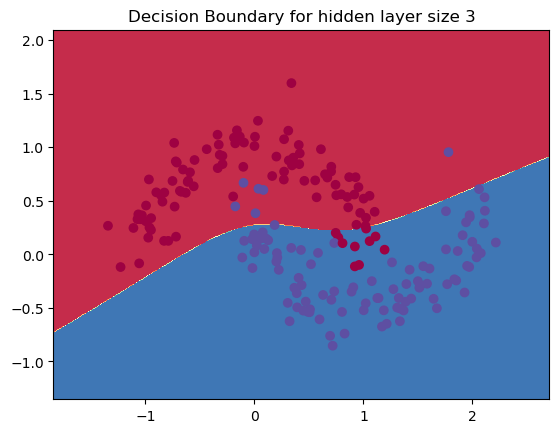

In [13]:
# Now Let's start the action
model_dict = init_network(input_dim = input_neurons , hidden_dim = 3, output_dim = output_neurons)
model = backpropagation(X, y, model_dict, 1000)
plot_decision_boundary(lambda x: predict(model, x))